# Obtaining the Data

Unfortunately, the data used here exceeds the file size limit of the github repository and is thus not included. The code is provided here anyways for demonstrational purposes. To dowload the data yourself, please refer to the reference section in the assignment submission.

# Traffic Estimates

For this task, to create a transport network, in which the nodes are cities and edges are direct transport links between two cities (Eg: Flights). Using nothing but the network topology itself, we were then asked to estimate the traffic (number of flights) for each transport link. The data set I found just so happened to have the actual number of flights between two cities, which was used to compare my results with. Although the assignment description says to use citoscape (not all students in our class had coding experience), our lecturer allowed us to use python instead for those who want an extra challenge.

For a more in depth discussion of my methods and results, please refer to my assignment submission included in this repository.

## Plotting Actual Air Traffic Data

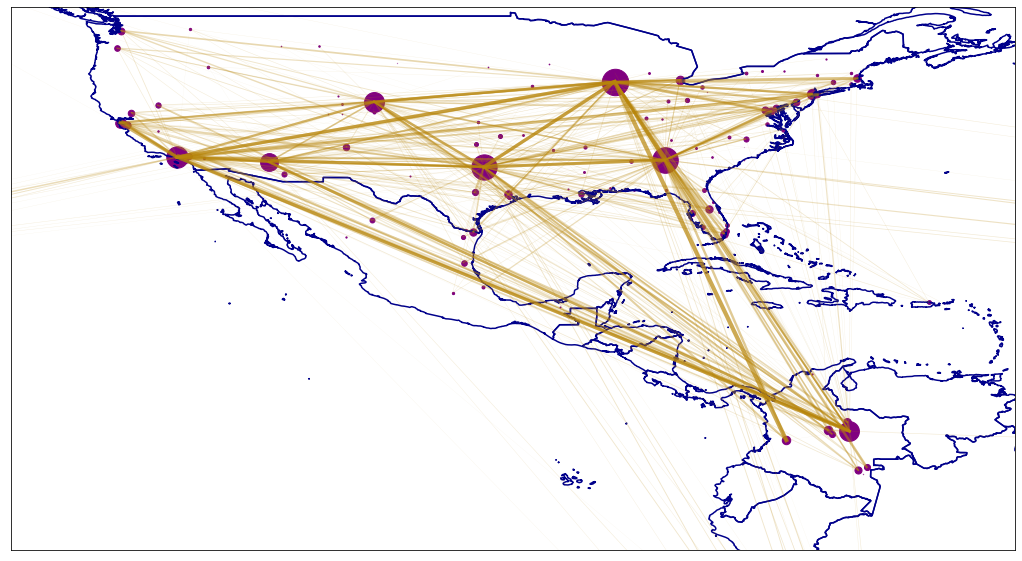

In [1]:
import json
import shapefile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# ===================================================== Maths ====================================================
# Normalizes the height map or optionally brings the heightmap within specified height limits
def normalizeArray(A, minValue=0.0, maxValue=1.0):
    A = A - min(A)
    A = A / (max(A) - min(A))
    return A * (maxValue - minValue) + minValue

# Coordinate transformation from spherical polar to cartesian
def polarToCartesian(radius, theta, phi, useLonLat=True):
    if useLonLat == True:
        theta, phi = np.radians(theta+180.), np.radians(90. - phi)
    X = radius * np.cos(theta) * np.sin(phi)
    Y = radius * np.sin(theta) * np.sin(phi)
    Z = radius * np.cos(phi)
    
    # Return data either as a list of XYZ coordinates or as a single XYZ coordinate
    if (type(X) == np.ndarray):
        return np.stack((X, Y, Z), axis=1)
    else:
        return np.array([X, Y, Z])

# ============================================= Reading and Preprocessing Data ===================================
# Read relevant coastline data
def readCoastData(countryDataDir='./Data/countries.geojson'):
    with open(countryDataDir) as f:
        return json.load(f)

# Read relevant data from 'FlightData.csv'
def readFlightData(flightDataDir='./Data/FlightData.csv'):
    flightDF = pd.read_csv(flightDataDir)
    flightOrigins = np.array(flightDF['origin'])
    flightDestination = np.array(flightDF['destination'])
    originUnique = np.unique(flightDF['origin'])
    numOfFlights = np.array(flightDF['num_of_flights'])
    numOfFlightsNorm = normalizeArray(numOfFlights)
    return (flightOrigins, flightDestination, originUnique, numOfFlights, numOfFlightsNorm)

# Read relevant data from 'airport-codes.csv'
def readAirportCodes(airportsDataDir='./Data/airport-codes.csv'):
    airportsDF = pd.read_csv(airportsDataDir)
    airportIATA = np.array(airportsDF['local_code'])
    airportLonLat = np.array(airportsDF['coordinates'])
    airportLonLat = [[line.split(',')[0], line.split(',')[1]] for line in airportLonLat]
    airportLonLat = np.array(airportLonLat).astype(float)
    return (airportIATA, airportLonLat)

#Map IATA codes to spherical and cartesian coordinates
def mapIATAcodes():
    IATAtoXYZ = {}
    IATAToLonLat = {}
    for i, iata in enumerate(airportIATA):
        if iata in originUnique:
            lon, lat = airportLonLat[i, 0], airportLonLat[i, 1]
            XYZ = polarToCartesian(earthRadius, lon, lat)
            IATAToLonLat[iata] = np.array([lon, lat])
            IATAtoXYZ[iata] = XYZ
    return IATAtoXYZ, IATAToLonLat

# Get degrees of airports
def getNodeDegrees():
    airportDegrees = np.zeros(len(originUnique))
    for i in range(len(flightOrigins)):
        origin = flightOrigins[i]
        destination = flightDestination[i]
        airportDegrees[np.argwhere(origin==originUnique)[0, 0]] += numOfFlights[i]
        airportDegrees[np.argwhere(destination==originUnique)[0, 0]] += numOfFlights[i]
    return normalizeArray(airportDegrees)

# ============================================= Plotting =============================================
# Add coastlines to plot
def plotCoastLines(ax, coastData):
    for nation in coastData['features']:
        for coords in nation['geometry']['coordinates']:
            if len(coords) > 1:
                lonLat = np.array(coords, dtype=object)
                if len(lonLat.shape) == 2:
                    ax.plot(lonLat[:, 0], lonLat[:, 1], color='darkblue')
            else:
                lonLat = np.array(coords[0])
                ax.plot(lonLat[:, 0], lonLat[:, 1], color='darkblue')
    return ax

# Add flight routes to plot with opacity and linewidth representing traffic
def plotFlightRoutes(ax, numFlights):
    for i in range(len(flightOrigins)):
        originLonLat = IATAToLonLat[flightOrigins[i]]
        destinationLonLat = IATAToLonLat[flightDestination[i]]
        x = [originLonLat[0], destinationLonLat[0]]
        y = [originLonLat[1], destinationLonLat[1]]
        opacity = 0.6 * numFlights[i] + 0.1
        thickness = 4.0 * numFlights[i] + 0.2
        ax.plot(x, y, color='darkgoldenrod', alpha=opacity, linewidth=thickness)
    return ax

# Plot the locations of airports (nodes)
def plotAirports(ax):
    for i, iata in enumerate(originUnique):
        deg = airportDegrees[i]
        lonLat = IATAToLonLat[iata]
        nodeSize = deg * 700
        ax.scatter(lonLat[0], lonLat[1], color='purple', s=nodeSize)
    return ax

# ============================================= Main Code ===============================================
# Read data
earthRadius = 6371
coastData = readCoastData()
flightOrigins, flightDestination, originUnique, numOfFlights, numOfFlightsNorm = readFlightData()
airportIATA, airportLonLat = readAirportCodes()
IATAtoXYZ, IATAToLonLat = mapIATAcodes()
airportDegrees = getNodeDegrees()

# Plot results
fig, ax = plt.subplots(figsize=(18, 10))
ax = plotCoastLines(ax, coastData)
ax = plotFlightRoutes(ax, numOfFlightsNorm)
ax = plotAirports(ax)
plt.xlim([-130, -60])
plt.ylim([-8, 50])
plt.xticks([])
plt.yticks([])
plt.show()


## Estimating Air Traffic

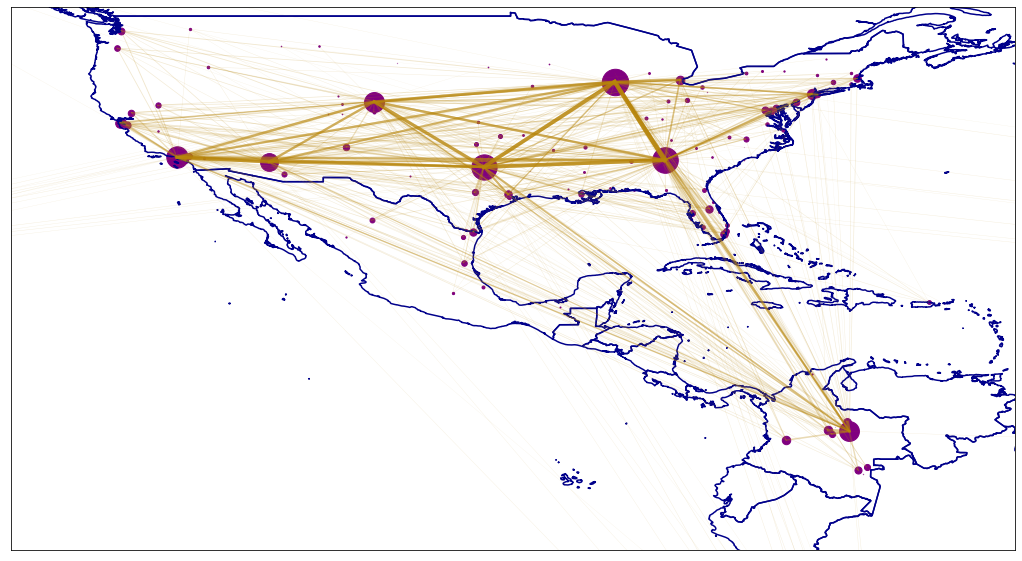

In [2]:
# Estimate air traffic purely from the flight network structure
def calculateTripDistribution():
    tripDistribution = np.zeros(len(flightOrigins))
    for i in range(len(flightOrigins)):
        origin = flightOrigins[i]
        destination = flightDestination[i]
        
        #Get distance of flight travel
        originXYZ = IATAtoXYZ[origin]
        destinationXYZ = IATAtoXYZ[destination]
        distOfTravel = np.sum((originXYZ - destinationXYZ)**2)**0.5
        
        #Get degrees of origin and destination airports
        originDegree = airportDegrees[np.argwhere(origin==originUnique)[0, 0]]
        destinationDegree = airportDegrees[np.argwhere(destination==originUnique)[0, 0]]
        
        #Calculate the trip distribution for this particular route (edge)
        tripDistribution[i] = (originDegree * destinationDegree / distOfTravel)**0.5
    return normalizeArray(tripDistribution)

# Get an estimate of flight traffic based on flight network alone
estimatedTraffic = calculateTripDistribution()

# Plot results
fig, ax = plt.subplots(figsize=(18, 10))
ax = plotCoastLines(ax, coastData)
ax = plotFlightRoutes(ax, estimatedTraffic)
ax = plotAirports(ax)
plt.xlim([-130, -60])
plt.ylim([-8, 50])
plt.xticks([])
plt.yticks([])
plt.show()

# Estimating Road Traffic

Unlike our air traffic data, our road data only contains the shape of roads and provides us no information about cities (nodes). Assuming that there lies a city at the end of every road, we can use clustering of the start/end points of roads to estimate where a city may lie. Both our estimates of city location and road traffic resembles that of actual data found online.

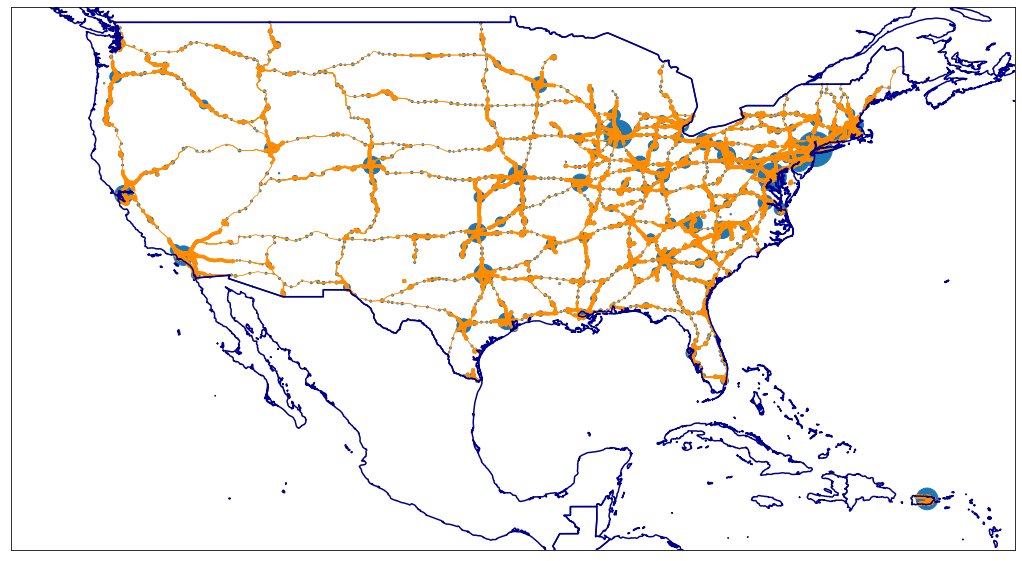

In [11]:
# Read road datafile
roadDataDir = 'Data/RoadData/tl_2016_us_primaryroads.shp'
roadShp = shapefile.Reader(roadDataDir)

# Extract network data from datafile
roadEndPoints = []
edges = []
for i, shp in enumerate(roadShp.shapes()):
    pts = np.array(shp.points)
    roadEndPoints.append(pts[0])
    roadEndPoints.append(pts[-1])
    edges.append([i*2, i*2+1])

# Convert to numpy arrays
roadEndPoints = np.array(roadEndPoints)
edges = np.array(edges)

# Run the clustering algorithm on road end points
cluster = DBSCAN(eps=0.2, min_samples=2, n_jobs=6).fit(roadEndPoints)
labels = cluster.labels_

# Use the centre of clusters to represent cities
clusterCentres = []
numPtsInCluster = []
for label in np.unique(labels):
    if label == -1:
        continue
    thisCluster = roadEndPoints[label==labels]
    centre = np.mean(thisCluster, axis=0)
    clusterCentres.append(centre)
    numPtsInCluster.append(thisCluster.shape[0])
clusterCentres = np.array(clusterCentres)

# Loop through all roads to calculate trip distribution and plot roads
fig, ax = plt.subplots(figsize=(18, 10))
for i, shp in enumerate(roadShp.shapes()):
    e = edges[i]
    pts = np.array(shp.points)
    leftLabel, rightLabel = labels[e[0]], labels[e[1]]
    
    # Make sure that the road ends bellong to a valid cluster, otherwise go to next iteration of this loop
    if (leftLabel==-1) or (rightLabel==-1):
        continue
    
    # Get size of cities at road endpoints
    leftClusterSize = np.sum(leftLabel==labels)
    rightClusterSize = np.sum(rightLabel==labels)
    
    # Get distance between to end points
    leftLonLat = pts[0]
    rightLonLat = pts[-1]
    leftXYZ = polarToCartesian(earthRadius, leftLonLat[0], leftLonLat[1])
    rightXYZ = polarToCartesian(earthRadius, rightLonLat[0], rightLonLat[1])
    distOfTravel = np.sum((leftXYZ - rightXYZ)**2)**0.5
    if distOfTravel == 0:
        continue
    
    # Calculate the trip distribution
    upperLimit = 100
    tripDistribution = (leftClusterSize * rightClusterSize / distOfTravel**0.5)
    if tripDistribution > upperLimit:
        tripDistribution = upperLimit
        
    # Plot roads with line thickness corresponding to trip distribution
    pts = np.array(shp.points)
    thickness = 3 * tripDistribution / upperLimit + 0.5
    ax.plot(pts[:, 0], pts[:, 1], color='darkorange', linewidth=thickness)

# Further Plotting
ax.scatter(clusterCentres[:, 0], clusterCentres[:, 1], s=numPtsInCluster)
ax = plotCoastLines(ax, coastData)
plt.xlim([-130, -60])
plt.ylim([15, 50])
plt.xticks([])
plt.yticks([])
plt.show()

# Minimum Spanning Trees (MST)

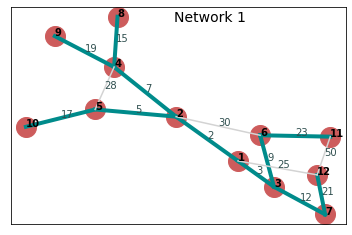

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Choose which network to analyse
chosenNetwork = 1

# Read data from file
dataDir = './Assign 3 Nets/Sn{}.txt'.format(chosenNetwork)
fileLines = open(dataDir).read().split('\n')[1:]
data = np.array([line.split() for line in fileLines if line!='']).astype(int)
edges = data[:, :2] - 1
weights = data[:, 2]

# Get coordinates of spring directed layout
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G, seed=1)
nodeCoords = np.array([pos[i] for i in np.arange(np.max(edges)+1)])
edgeCoords = np.array([[pos[e[0]], pos[e[1]]] for e in edges])
numberOfNodes = len(nodeCoords)

# List of nodes that are already in the MST
nodesInMST = [0]

# List of ones and zeros of same length and order as list of edges of main network
# A one indicates this edge is part of MST, zero otherwise
isMSTedge = np.zeros(len(edges))

# Run loop while we still haven't traversed all nodes
while len(set(nodesInMST)) != numberOfNodes:
    
    # For each traversed node: 
    # - Get weights of all edges that aren't allready part of the MST
    # - Get the node on other side of those edges
    idx = []
    otherNode = []
    weightsToChoseFrom = []
    for node in nodesInMST:
        for i, e in enumerate(edges):
            
            # Conditions to check for each edge in network
            edgeContainsThisNode = (node in e)
            isNotAlreadyPartOfMST = (isMSTedge[i] == 0)
            atLeastOneNodeOnEdgeIsNotPartOfMST = ((e[0] not in nodesInMST) or (e[1] not in nodesInMST))
            
            # If this edge satisfies all conditions, consider this edge as a possible MST edge
            if edgeContainsThisNode and isNotAlreadyPartOfMST and atLeastOneNodeOnEdgeIsNotPartOfMST:
                idx.append(i)
                other = e[e!=node]
                otherNode.append(other[0])
                weightsToChoseFrom.append(weights[i])
    
    # Add the lightest edge to the MST
    minWeightIndex = np.argmin(weightsToChoseFrom)
    isMSTedge[idx[minWeightIndex]] = 1
    nodesInMST.append(otherNode[minWeightIndex])

# Draw edges and weight labels
for i, e in enumerate(edgeCoords):
    centre = np.mean([e[:, 0], e[:, 1]], axis=1)
    if isMSTedge[i] == 1:
        plt.plot(e[:, 0], e[:, 1], color='darkcyan', linewidth=4)
    else:
        plt.plot(e[:, 0], e[:, 1], color='lightgrey')
    plt.text(centre[0], centre[1], s=weights[i], color='darkslategray')

# Draw node labels
labels = (np.arange(numberOfNodes)+1).astype(str)
for i in range(len(nodeCoords)):
    plt.text(nodeCoords[i, 0], nodeCoords[i, 1], s=labels[i], color='black', weight="bold")

# Draw nodes
plt.scatter(nodeCoords[:, 0], nodeCoords[:, 1], color='indianred', s=400)
plt.text(
    (-max(nodeCoords[:, 0]) - min(nodeCoords[:, 0])) / 2, .95 * max(nodeCoords[:, 1]),
    fontsize=14,
    s='Network {}'.format(chosenNetwork), 
    horizontalalignment='center')
plt.xticks([])
plt.yticks([])
plt.show()
